In [4]:
import numpy as np
import pandas as pd
import networkx as nx
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
__location__ = os.path.realpath(os.path.join(os.getcwd(), os.path.dirname(__file__)))
file_nodes = os.path.join(os.getcwd(), "dataset/user_nodes.csv")
file_edges = os.path.join(os.getcwd(), "dataset/user_edges.csv")

user_nodes = pd.read_csv(file_nodes)
user_edges = pd.read_csv(file_edges)

In [16]:
user_nodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1610 entries, 0 to 1609
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   _id             1610 non-null   float64
 1   followersCount  1610 non-null   float64
 2   friendsCount    1610 non-null   float64
 3   statusCount     1610 non-null   float64
 4   tweet_count     1610 non-null   float64
dtypes: float64(5)
memory usage: 63.0 KB


In [8]:
#1. read nodes and edges from pandas dataframe
G=nx.convert_matrix.from_pandas_edgelist(user_edges, "_id", "followers")

#2. save as a gephi file
nx.write_gexf(G, "/home/simon/gitRepo/network-analysis-using-python-and-R/dataset/network.gexf")

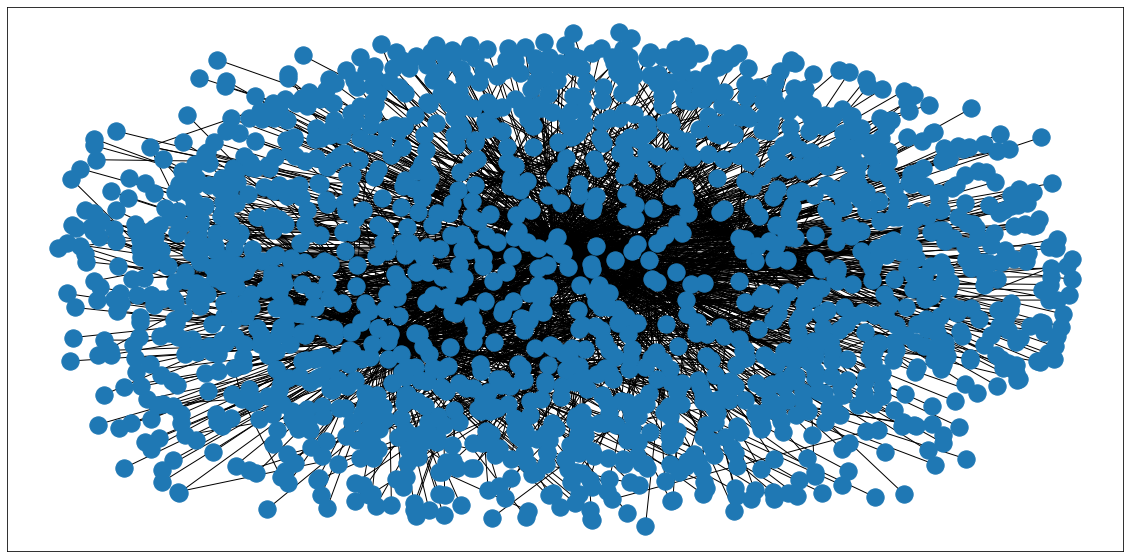

In [7]:
## plot network using networkx
fig, ax = plt.subplots(figsize=(20,10))
pos = nx.spring_layout(G, k=0.08, iterations=10, scale=4)
nx.draw_networkx(G,pos, with_labels=False)

# the figure isn't well layout, we will use Gephi to manipulate the network layout
# open network.gexf file in Gephi application and manipulate it, once we are satisfied with the layout, we save it as xxx.gexf file

In [105]:
## get coordinates from processed gephi file

def extract_coord(gephi_path, label_name_dtype = "str"):
    g = pd.read_csv(gephi_path)
    label_name = g[g.columns.values[0]].str.extract(r'label="(.+?)"')
    node_degree = g[g.columns.values[0]].str.extract(r'value="(.+?)"')
    X = g[g.columns.values[0]].str.extract(r'x="(.+?)"')
    Y = g[g.columns.values[0]].str.extract(r'y="(.+?)"')
    node_degree = node_degree[1:].append([np.nan],ignore_index=True)
    X = X[2:].append([np.nan, np.nan], ignore_index=True)
    Y = Y[2:].append([np.nan, np.nan], ignore_index=True)
    df = pd.concat([label_name, node_degree, X, Y], axis=1)
    df.dropna(axis=0, how="any", inplace=True)
    df.columns = ["node_id", "node_degree", "X", "Y"]
    df.drop_duplicates(inplace=True)
    cvt_dtype_cols = ["node_degree", "X", "Y"]
    cvt_dtype_types = [np.float64, np.float64, np.float64]
    df = df.astype(dict(zip(cvt_dtype_cols, cvt_dtype_types)))
    if label_name_dtype == "numeric":
        df.loc[:, "node_id"] = df.loc[:,"node_id"].astype(np.float64)
    return df

gephi_path = os.path.join(os.getcwd(),"/dataset/network_gephi.gexf")
gephi_df = extract_coord(gephi_path, label_name_dtype = "numeric")

In [107]:
## manipulate the dataframe to make it Tableau ready

def stack_user_edges(user_edges, src, tgt):
    """
    """
    user_edges["key"] = [x+1 for x in range(user_edges.shape[0])] # add key for building network in Tableau
    user_edges_cp = user_edges.copy()
    user_edges_cp[[src, tgt]] = user_edges[[tgt, src]]
    appended_df = user_edges.append(user_edges_cp)
    return appended_df

def merge_nodes_edges(gephi_df, appended_df, gephi_df_key, appended_df_key):
    return gephi_df.merge(appended_df, left_on = gephi_df_key, right_on = appended_df_key, how = "inner")

append_df = stack_user_edges(user_edges, "_id", "followers")
df_tableau_ready = merge_nodes_edges(gephi_df, append_df, "node_id", "_id")
df_tableau_ready.to_csv(r"dataset/df_tableau_network.csv", index = False)

In [115]:
df_tableau_ready.head()

,node_id,node_degree,X,Y,_id,followers,key
0,3639.0,10.421053,-400.40414,-1034.58,3639,121983,1
1,3639.0,10.421053,-400.40414,-1034.58,3639,114361,2
2,3639.0,10.421053,-400.40414,-1034.58,3639,133932,3
3,3639.0,10.421053,-400.40414,-1034.58,3639,593498,4
4,3639.0,10.421053,-400.40414,-1034.58,3639,107879,5


In [ ]:
### plot in Tableau

1. read in the saved csv file "df_tableau_network.csv" as txt file, select an empty sheet in Tableau
2. drag X into Columns, drag Y twice into Rows, set all X and Y into dimension data types
3. on Marks section, change Y(2) to Line type
4. right click one of the Y, select "Dual Axis"
5. right click the merged Y, select "Synchronize Axis"
6. add "key" column to Y(2) detail
7. fine-tuning the edge thickness, color, and nodes thickness, color, etc.

In [55]:
## prepare node attributes for network graph using networkx

node_attrs = {ids:{"pos":(x, y)} for ids, (x, y) in zip(gephi_df.node_id.values.astype(np.int32).tolist(),
                                           zip(gephi_df.X.values.astype(np.float64).tolist(), gephi_df.Y.values.astype(np.float64).tolist()))}
for ids, node_degree in zip(gephi_df.node_id.values.astype(np.int32).tolist(),gephi_df.node_degree.values.astype(np.float64).tolist()):
    node_attrs[ids]["degree"] = node_degree
    

In [49]:
## set node attributes to graph object

G1 = nx.convert_matrix.from_pandas_edgelist(user_edges, "_id", "followers")
nx.set_node_attributes(G1, node_attrs)

In [78]:
## set up discrete color based on the degree centrality

color_map = []
for node in list(G1.degree):
    if node[1] < 15:
        color_map.append("cornflowerblue")
    elif node[1] >= 15 and node[1] < 25:
        color_map.append("cyan")
    else:
        color_map.append("orange")

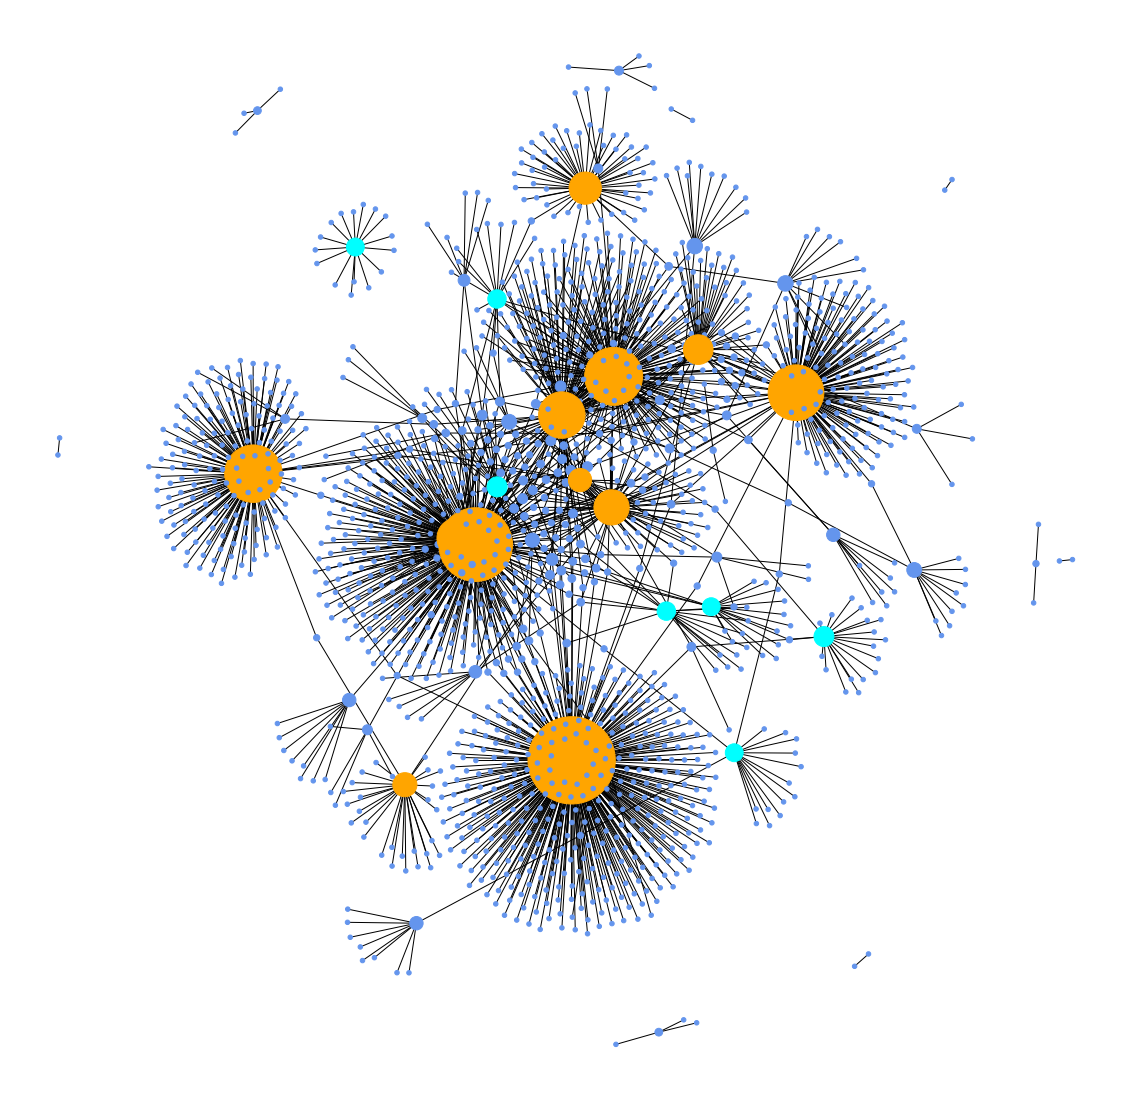

In [79]:
## plot the Gephi processed networks using python networkx

coords = {user_id:(x, y) for user_id, (x, y) in nx.get_node_attributes(G1, 'pos').items()}
fig, ax = plt.subplots(figsize = (20, 20))
dg = dict(G1.degree)
nx.draw(G1, coords, with_labels = False, node_size = [v*20 for v in dg.values()], node_color = color_map)